In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from pathlib import Path 
import pandas as pd

plt.rcParams['figure.figsize'] = (4, 3) 

Read AnnData

In [ ]:
path_scrnaseq = "/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted.h5ad"
adata = sc.read_h5ad(path_scrnaseq)

In [ ]:
adata

## Collect genes to keep 

In [12]:
# Read the codex to RNA
codex_matching_ensembl = pd.read_csv("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/codex/codex_matching_ensembl.tsv", sep="\t")
codex_matching_ensembl.shape

(59, 6)

Remove NaNs 

In [13]:
codex_matching_ensembl = codex_matching_ensembl[codex_matching_ensembl['gene_ids_present_in_dataset'].notna()]

In [14]:
codex_matching_ensembl

,Codex_Name,gene_id,gene_ids_present_in_dataset,HGNC_ID,Comment,Unnamed: 5
1,HLA-DR,NaN,"ENSG00000204287,ENSG00000198502,ENSG00000196126",4947.0,"HLA-DRA, HLA-DRB5,HLA-DRB1 were found in the g...",NaN
2,S100,Multiple,ENSG00000196154,NaN,Based on an alternative study published by the...,NaN
3,MCT,Multiple,ENSG00000232119,NaN,"MCT family is quite large, unclear which prote...",NaN
5,CD45,"ENSG00000262418,ENSG00000081237",ENSG00000081237,9666.0,Only one of the transcript ids found in dataset,NaN
8,CD8,"ENSG00000153563,ENSG00000172116","ENSG00000153563,ENSG00000172116",NaN,CD8A and CD8B,NaN
9,CD3,"ENSG00000198851,ENSG00000160654,ENSG00000167286","ENSG00000198851,ENSG00000160654,ENSG00000167286",NaN,"CD3E, CD3D, and CD3G",NaN
10,CD16,"ENSG00000203747,ENSG00000162747","ENSG00000203747,ENSG00000162747",NaN,"CD16a, CD16b",NaN
11,CollagenIV,"ENSG00000187498,ENSG00000134871,ENSG0000016903...","ENSG00000187498,ENSG00000134871,ENSG0000016903...",NaN,"COL4A1, COL4A2, COL4A3, COL4A4, COL4A5, COL4A6",NaN
12,CHGA,"ENSG00000276781,ENSG00000100604",ENSG00000100604,NaN,Only one of the transcript ids found in dataset,NaN
13,PD-1,"ENSG00000188389,ENSG00000276977",ENSG00000188389,NaN,Only one of the transcript ids found in dataset,NaN


In [15]:
codex_matching_ensembl.shape

(55, 6)

## Unique genes 

In [18]:
expression_matrx = np.zeros((adata.shape[0], codex_matching_ensembl.shape[0]))
gene_columns = []

for i, gene in enumerate(codex_matching_ensembl.gene_ids_present_in_dataset):
    gene_split = gene.split(",")
    
    if len(gene_split)==1:
        expression_matrx[:, i] = adata[:, adata.var["gene_id"]==gene].layers["logcounts"].squeeze()
    else:
        expression_matrx[:, i] = adata[:, adata.var["gene_id"].isin(gene_split)].layers["logcounts"].max(1)
    # Save gene column names
    gene_columns.append(gene)

Checks for correctness

In [24]:
expression_matrx.sum(0)==0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [26]:
adata_reduced = sc.AnnData(X=expression_matrx, obs=adata.obs)

In [30]:
adata_reduced.var.index= gene_columns

In [39]:
adata_reduced.obsm = adata.obsm

Save anndata object separately for all and discovery

In [50]:
np.unique(adata_reduced.obs.cohort_type, return_counts=True)

(array(['discovery', 'validation'], dtype=object), array([263286, 199066]))

In [51]:
adata_reduced.write_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_total.h5ad")

In [52]:
adata_reduced[adata_reduced.obs.cohort_type=='discovery'].write_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_discovery.h5ad")

# Check correspondence in cell type discovery and non-discovery

In [27]:
adata_reduced = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_total.h5ad")
adata_reduced_discovery = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_total.h5ad")

In [31]:
adata_reduced.obsm["X_umap"] = adata_reduced.obsm["UMAP"]
adata_reduced_discovery.obsm["X_umap"] = adata_reduced_discovery.obsm["UMAP"]

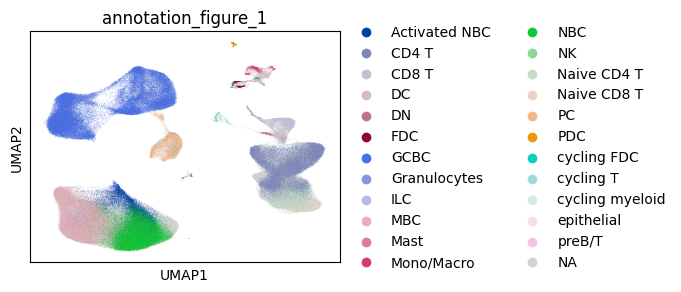

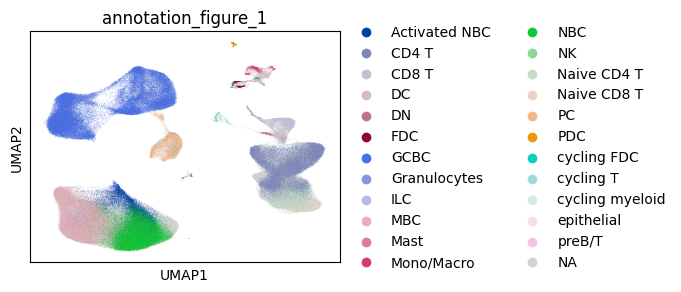

In [32]:
sc.pl.umap(adata_reduced, color="annotation_figure_1")
sc.pl.umap(adata_reduced_discovery, color="annotation_figure_1")

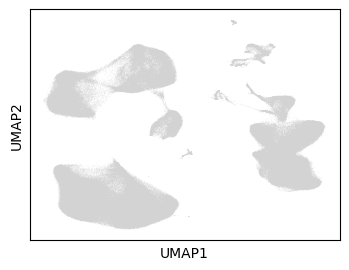

In [33]:
sc.pl.umap(adata_reduced)